### Dataset Information:

1. date: Date in format dd/mm/yyyy

2. time: time in format hh:mm:ss

3. globalactivepower: household global minute-averaged active power (in kilowatt)

4. globalreactivepower: household global minute-averaged reactive power (in kilowatt)

5. voltage: minute-averaged voltage (in volt)

6. global_intensity: household global minute-averaged current intensity (in ampere)

7. submetering1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).

8. submetering2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.

9. submetering3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

In [1]:
import pandas as pd
import numpy as np

import time

import os

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


import math

import tensorflow as tf
from tensorflow.keras.utils import Sequence
from datetime import timedelta
from sklearn.metrics import mean_squared_error

from tensorflow.keras import layers , activations , models , preprocessing , utils
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential

In [2]:
df=pd.read_csv(r'household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [3]:
df = df.replace('?', np.nan)
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [4]:
def fill_missing(values):
    one_day = 60*24
    for row in range(df.shape[0]):
        for col in range(df.shape[1]):
            if np.isnan(values[row][col]).any():
                values[row,col] = values[row-one_day,col]
                
df = df.astype('float32')
fill_missing(df.values)
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

The dataframe is huge so we will use downsampling from minitue to day

In [5]:
daily_df = df.resample('D').sum()
daily_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16,1209.176025,34.922001,93552.53125,5180.799805,0.0,546.0,4926.0
2006-12-17,3390.459961,226.005997,345725.31250,14398.599609,2033.0,4187.0,13341.0
2006-12-18,2203.825928,161.792007,347373.62500,9247.200195,1063.0,2621.0,14018.0
2006-12-19,1666.193970,150.942001,348479.00000,7094.000000,839.0,7602.0,6197.0
2006-12-20,2225.748047,160.998001,348923.62500,9313.000000,0.0,2648.0,14063.0


In [6]:
daily_df.shape

(1442, 7)

In [7]:
train_df_len = round(len(daily_df)*0.8)

train_df, test_df = daily_df[:train_df_len], daily_df[train_df_len:]  # 80% and 20%
train_df.shape,test_df.shape

((1154, 7), (288, 7))

In [8]:
train = train_df
scalers={}

for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(0,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s

test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

<ipython-input-8-00bb3218fd75>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
<ipython-input-8-00bb3218fd75>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
<ipython-input-8-00bb3218fd75>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tr

In [9]:
train.shape, test.shape

((1154, 7), (288, 7))

### Transform dataset

Transform the dataset with each row representing the historical data and the target using Window Sliding.<br>
<br>
__Window Sliding__:This approach followed for all the models of this work is to reshape the information we have by fixed windows that will give the model the most complete information possible at a given time point from the recent past, in order to achieve an accurate prediction.
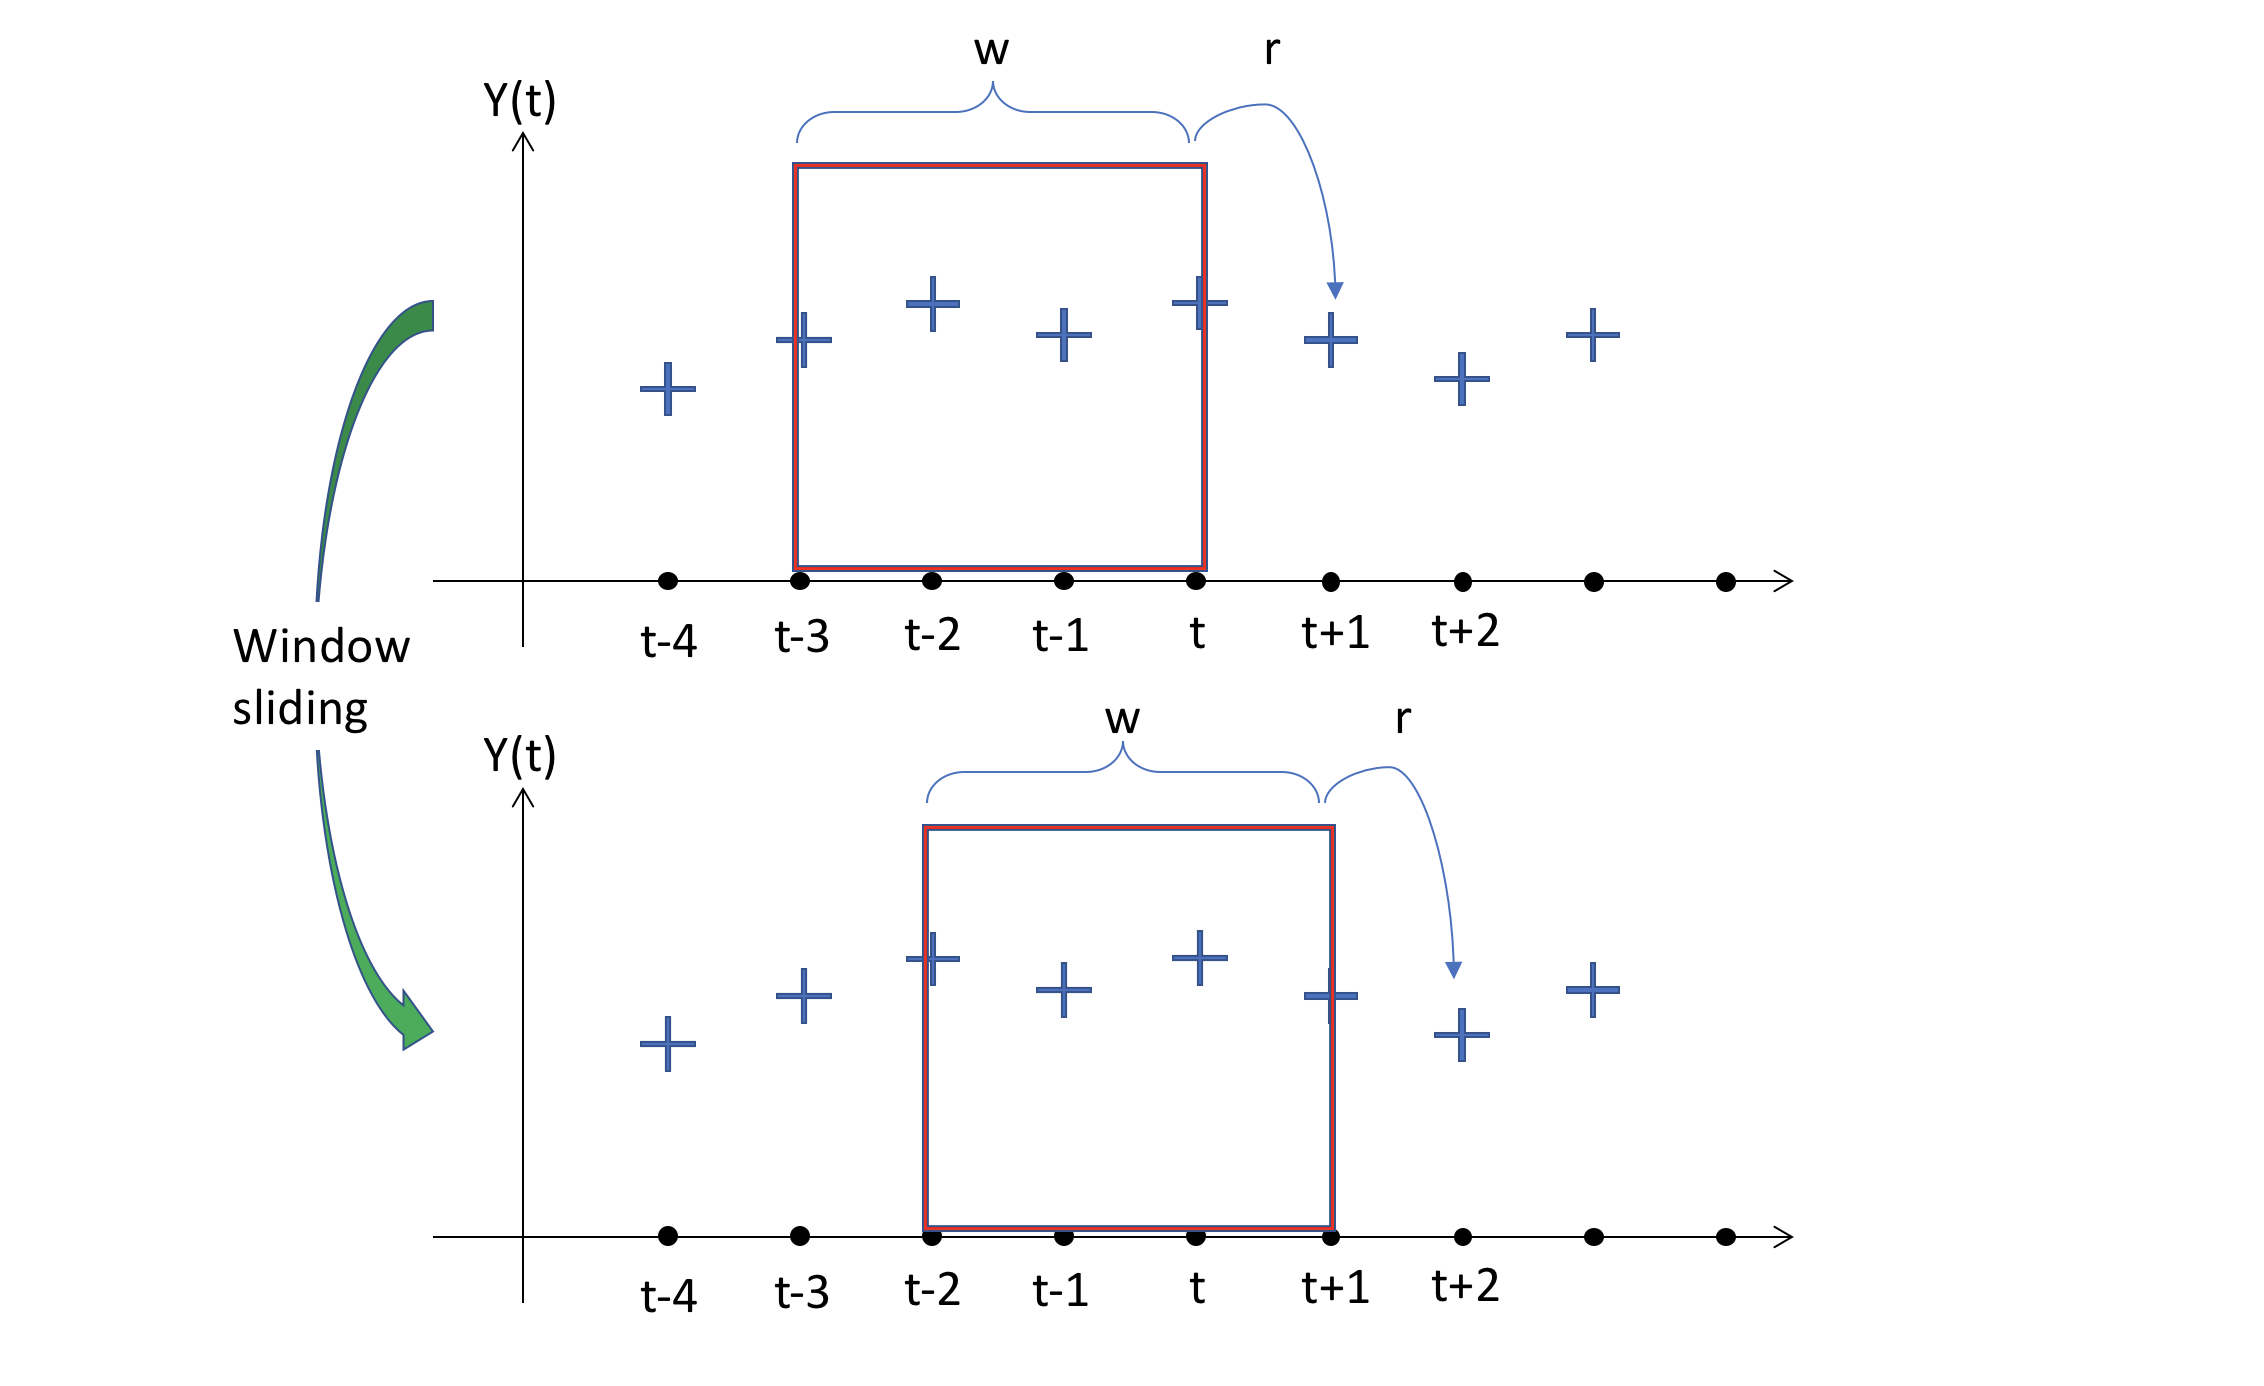

We will to divide the new dataset into smaller files at the same time, which is easier to process and faster.

In [10]:
def LSTM_prep(series, n_past, n_future):
    
    X, y = list(), list()
    
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        
        if future_end > len(series):
              break
                
        # window slicing
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
        
    return np.array(X), np.array(y)

In [11]:
def ANN_prep(series, n_past, n_future):
    
    X, y = [], []
    
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        
        if future_end > len(series):
              break
                
        # window slicing
        past, future = series[window_start:past_end, :].reshape((1,-1)), series[past_end:future_end,0]
        past = past.reshape((1,-1))
        #future = future.reshape((1,))
        #X = np.concatenate((X,past))
        #y = np.concatenate((y,future))
        X.append(past)
        y.append(future)

        
    return np.array(X), np.array(y)

In [12]:
# Given past 7 days observation, forecast the next 1 days observations. 
n_past = 7
n_future = 1 
n_features = 7

In [13]:
X_train_3D, y_train_3D = LSTM_prep(train.values,n_past, n_future)
X_test_3D, y_test_3D = LSTM_prep(test.values,n_past, n_future)

In [14]:
X_train_3D = X_train_3D.reshape((X_train_3D.shape[0], X_train_3D.shape[1],n_features))
y_train_3D = y_train_3D.reshape((y_train_3D.shape[0], y_train_3D.shape[1], n_features))

X_test_3D = X_test_3D.reshape((X_test_3D.shape[0], X_test_3D.shape[1],n_features))
y_test_3D = y_test_3D.reshape((y_test_3D.shape[0], y_test_3D.shape[1], n_features))

In [15]:
X_train_3D.shape, y_train_3D.shape

((1147, 7, 7), (1147, 1, 7))

In [16]:
X_train_2D, y_train_2D = ANN_prep(train.values,n_past, n_future)
X_test_2D, y_test_2D = ANN_prep(test.values,n_past, n_future)

In [17]:
X_train_2D.shape, X_test_2D.shape

((1147, 1, 49), (281, 1, 49))

In [18]:
X_train_2D = X_train_2D.reshape((1147,-1))
X_test_2D = X_test_2D.reshape((281,-1))

In [19]:
X_train_2D.shape, X_test_2D.shape

((1147, 49), (281, 49))

# Fitting model

In [20]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose = 2)
shape = X_train_2D.shape[1]

## Artificial Neural Network

A Feed Forward Neural Network is an artificial neural network in which the connections between nodes does not form a cycle.

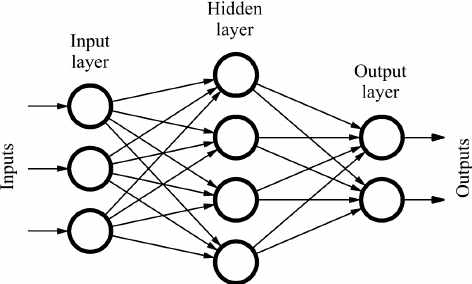

In [21]:
model1 = models.Sequential()
model1.add(layers.InputLayer(input_shape=(shape)))
model1.add(layers.Dense(32, activation='sigmoid'))
model1.add(layers.Dense(64, activation='sigmoid'))
model1.add(layers.Dense(128, activation='sigmoid'))
model1.add(layers.Dense(1, activation='softmax'))

model1.compile(loss='mse',optimizer='adam', metrics = ['mse'])
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                1600      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 12,161
Trainable params: 12,161
Non-trainable params: 0
_________________________________________________________________


In [22]:
%%time

# train in batch sizes of 32.
BATCH_SIZE = 32
NUM_EPOCHS = 50

history1 = model1.fit(x=X_train_2D, y=y_train_2D, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_split = 0.1, callbacks=[es])

y_pred1 = model1.predict(X_test_2D)
print('\nMSE of predict test:',mean_squared_error(y_test_2D, y_pred1))

Epoch 1/50
33/33 [==============================] - 1s 21ms/step - loss: 0.5375 - mse: 0.5375 - val_loss: 0.3981 - val_mse: 0.3981
Epoch 2/50
33/33 [==============================] - 0s 1ms/step - loss: 0.5237 - mse: 0.5237 - val_loss: 0.3981 - val_mse: 0.3981
Epoch 00002: early stopping

MSE of predict test: 0.5553832
Wall time: 1.06 s


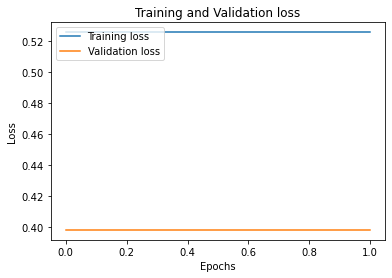

In [23]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Training and Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training loss', 'Validation loss'], loc='upper left')
plt.show()

In [24]:
model2 = models.Sequential()
model2.add(layers.InputLayer(input_shape=(shape)))
model2.add(layers.Dense(64, activation='sigmoid'))
model2.add(layers.Dense(32, activation='sigmoid'))
model2.add(layers.Dense(1, activation='softmax'))

model2.compile(loss='mse',optimizer='adam', metrics=['mse'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                3200      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 5,313
Trainable params: 5,313
Non-trainable params: 0
_________________________________________________________________


In [25]:
%%time

# train in batch sizes of 32.
BATCH_SIZE = 32
NUM_EPOCHS = 50

history2 = model2.fit(x=X_train_2D, y=y_train_2D, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_split = 0.1, callbacks=[es])

y_pred2 = model2.predict(X_test_2D)
print('\nMSE of predict test:',mean_squared_error(y_test_2D, y_pred2))

Epoch 1/50
33/33 [==============================] - 0s 4ms/step - loss: 0.5187 - mse: 0.5187 - val_loss: 0.3981 - val_mse: 0.3981
Epoch 2/50
33/33 [==============================] - 0s 1ms/step - loss: 0.5223 - mse: 0.5223 - val_loss: 0.3981 - val_mse: 0.3981
Epoch 00002: early stopping

MSE of predict test: 0.5553832
Wall time: 418 ms


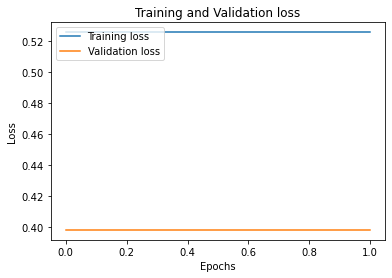

In [26]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Training and Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training loss', 'Validation loss'], loc='upper left')
plt.show()

In [27]:
model3 = models.Sequential()
model3.add(layers.InputLayer(input_shape=(shape)))
model3.add(layers.Dense(32, activation='tanh'))
model3.add(layers.Dense(64, activation='tanh'))
model3.add(layers.Dense(1, activation='softmax'))

model3.compile(loss='mse',optimizer='adam', metrics=['mse'])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 32)                1600      
_________________________________________________________________
dense_8 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 3,777
Trainable params: 3,777
Non-trainable params: 0
_________________________________________________________________


In [28]:
%%time

# train in batch sizes of 32.
BATCH_SIZE = 32
NUM_EPOCHS = 50

history3 = model3.fit(x=X_train_2D, y=y_train_2D, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_split = 0.1, callbacks=[es])

y_pred3 = model3.predict(X_test_2D)
print('\nMSE of predict test:',mean_squared_error(y_test_2D, y_pred3))

Epoch 1/50
33/33 [==============================] - 0s 8ms/step - loss: 0.5372 - mse: 0.5372 - val_loss: 0.3981 - val_mse: 0.3981
Epoch 2/50
33/33 [==============================] - 0s 1ms/step - loss: 0.5161 - mse: 0.5161 - val_loss: 0.3981 - val_mse: 0.3981
Epoch 00002: early stopping

MSE of predict test: 0.5553832
Wall time: 565 ms


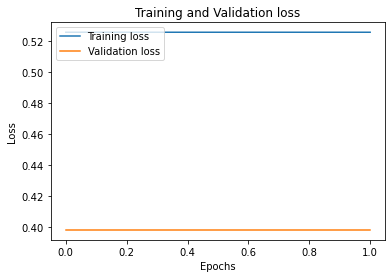

In [29]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Training and Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training loss', 'Validation loss'], loc='upper left')
plt.show()

## LSTM

### RNN

Humans don’t start their thinking from scratch every second. As you read this essay, you understand each word based on your understanding of previous words. You don’t throw everything away and start thinking from scratch again. Your thoughts have persistence. So Recurrent neural networks address this issue. They are networks with loops in them, allowing information to persist.

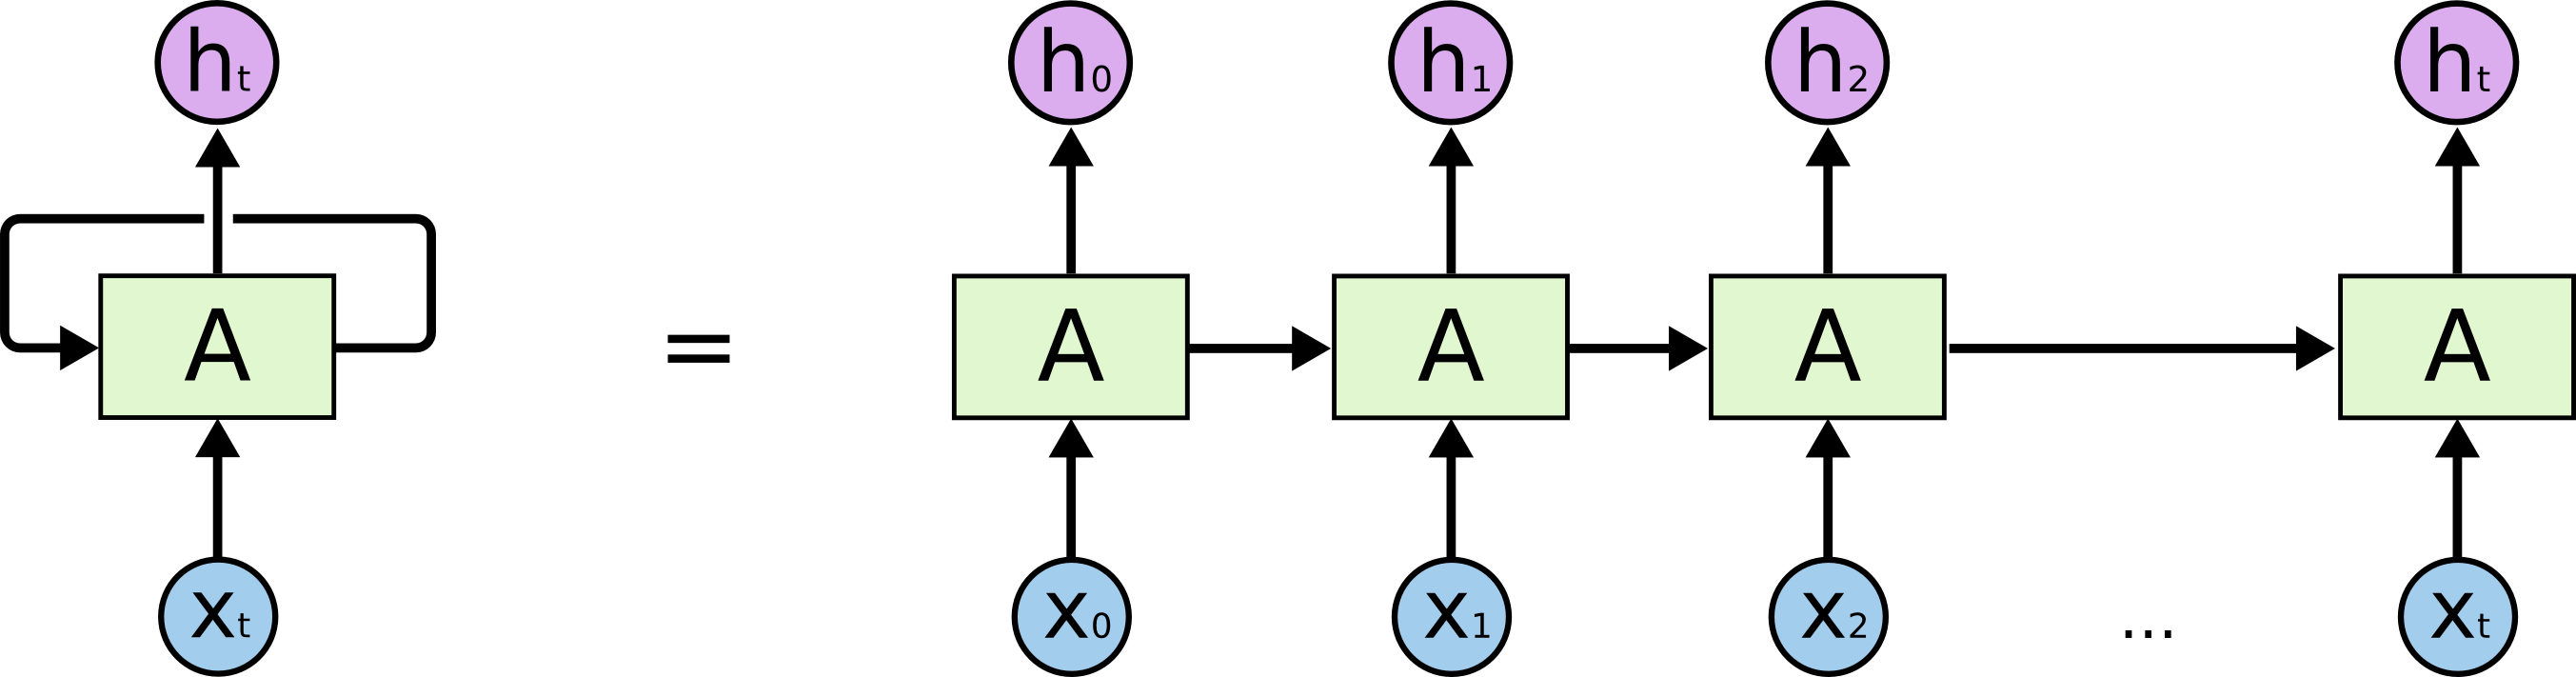

In such cases, where the gap between the relevant information and the place that it’s needed is small, RNNs can learn to use the past information.

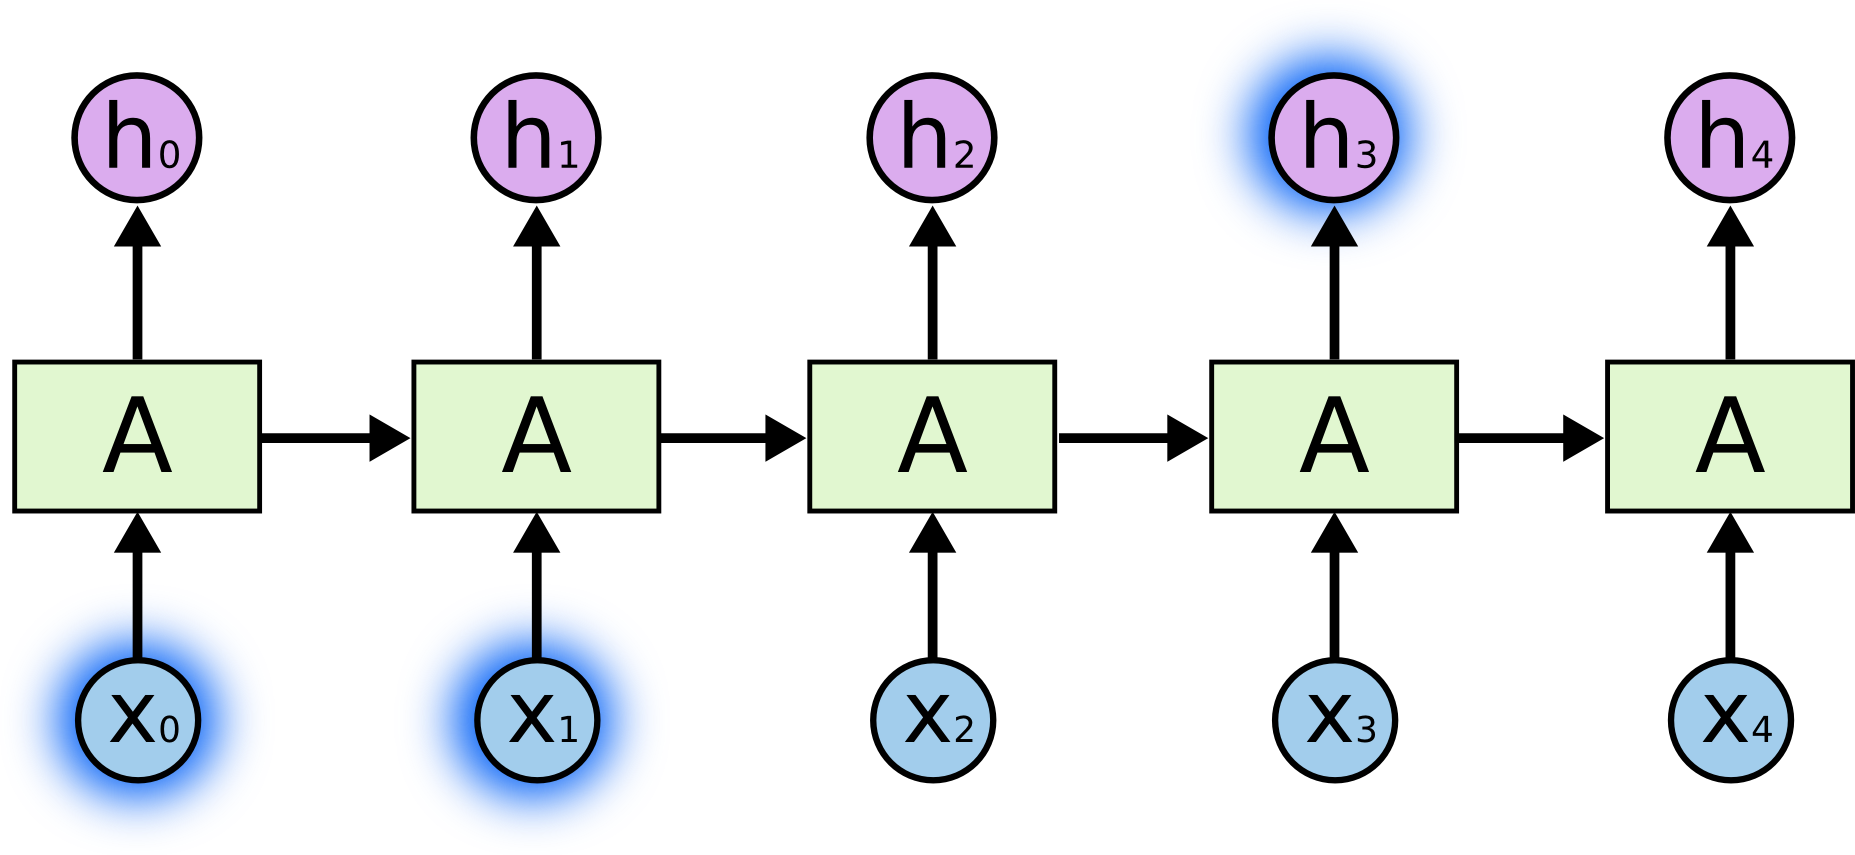

It’s entirely possible for the gap between the relevant information and the point where it is needed to become very large. RNNs become unable to learn to connect the information

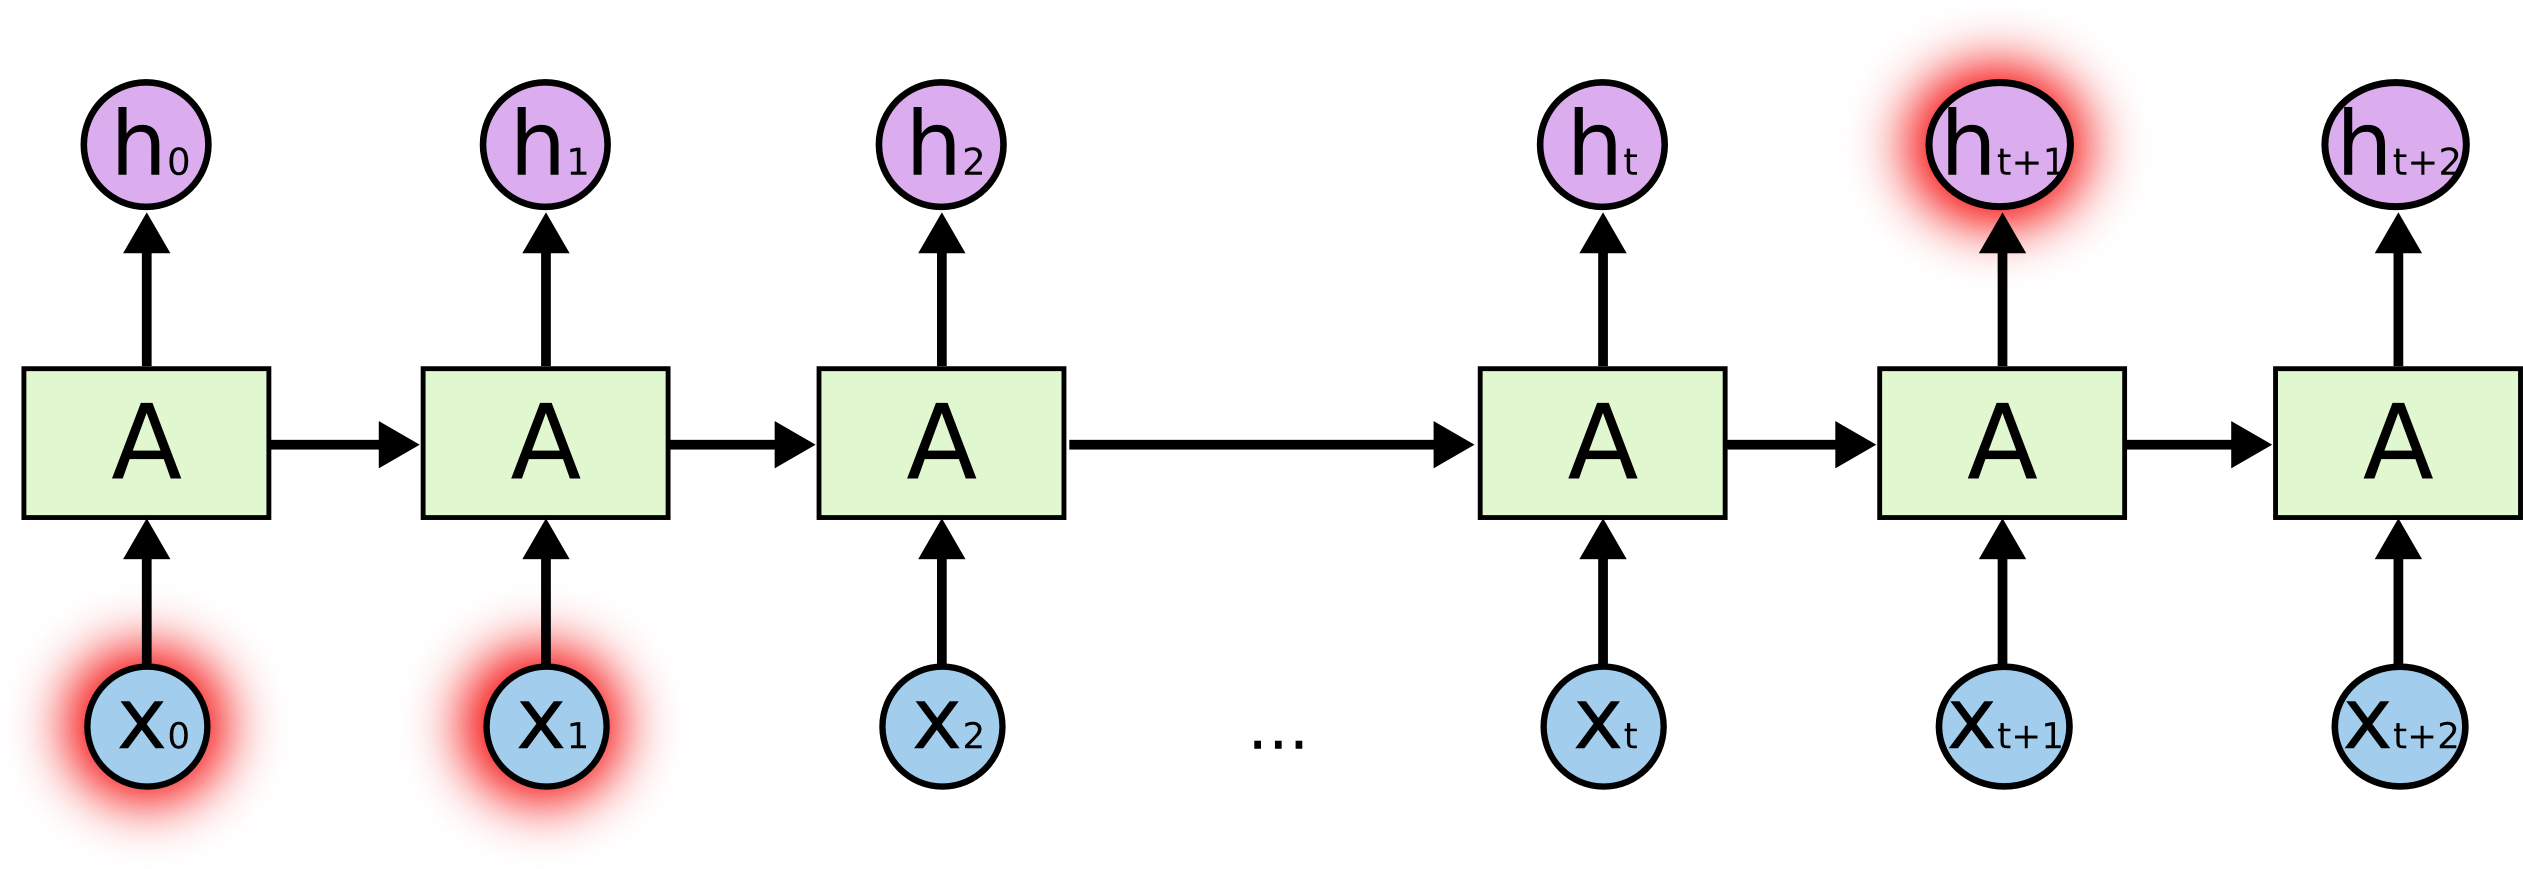

### LSTM

LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!

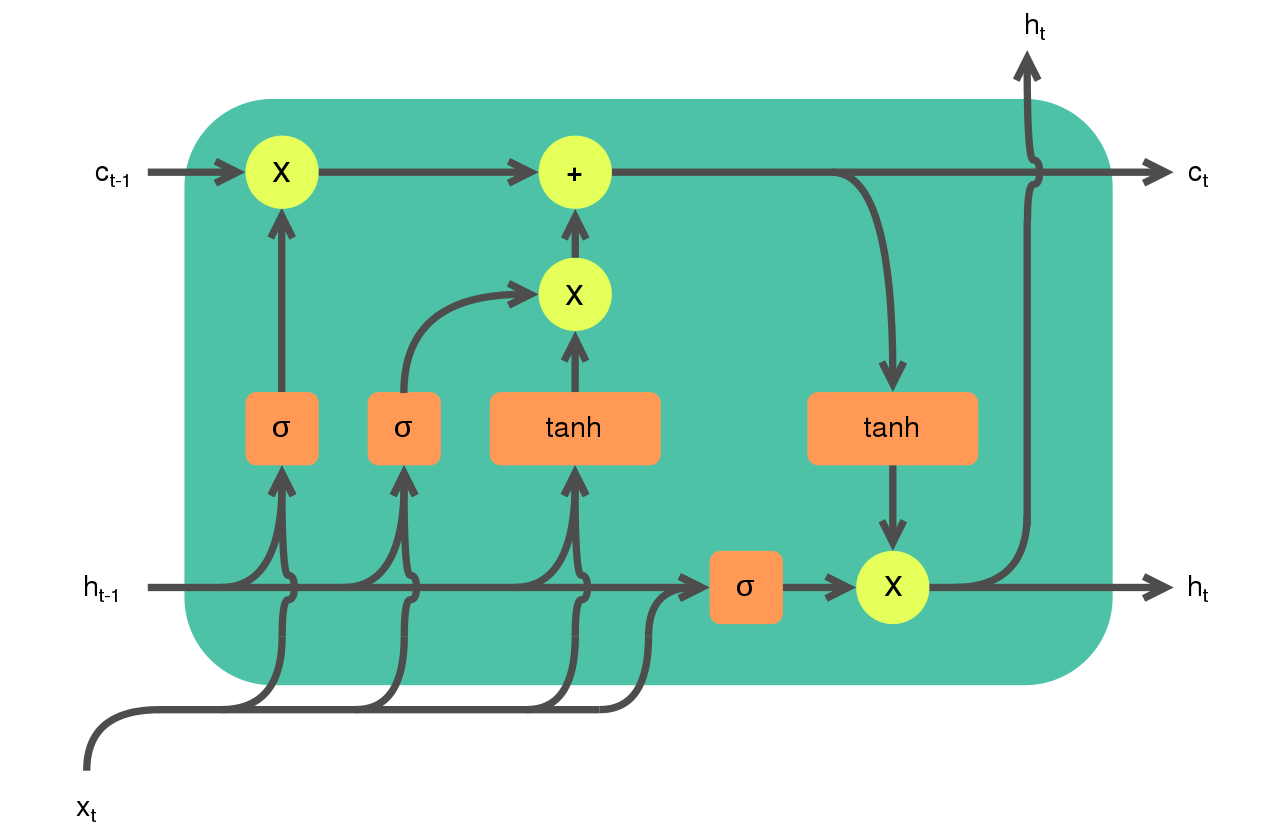

At a first sight, this looks intimidating. Let’s ignore the internals, but only look at the inputs and outputs of the unit. The network takes three inputs. X_t is the input of the current time step. h_t-1 is the output from the previous LSTM unit and C_t-1 is the “memory” of the previous unit, which I think is the most important input. As for outputs, h_t is the output of the current network. C_t is the memory of the current unit.

Forget Gate
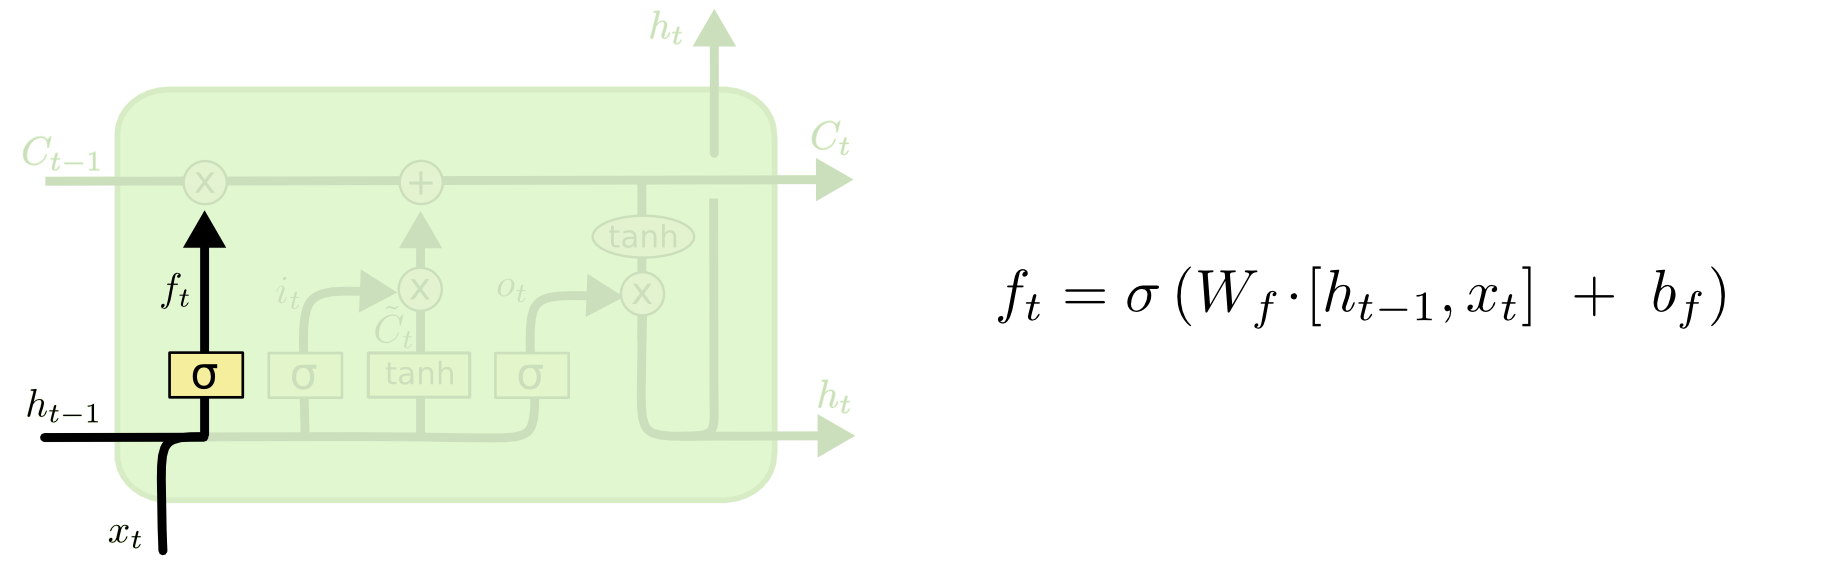

Input Gate
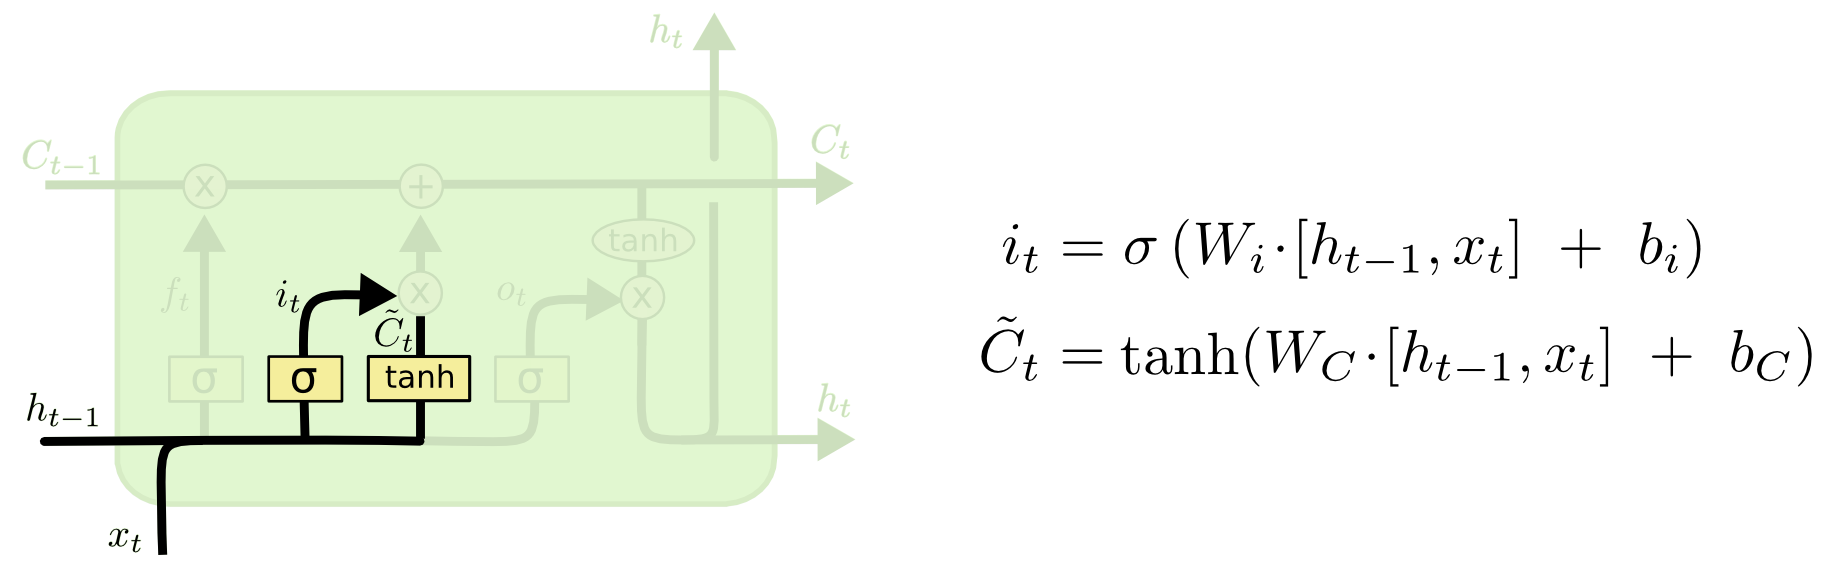

Update Cell
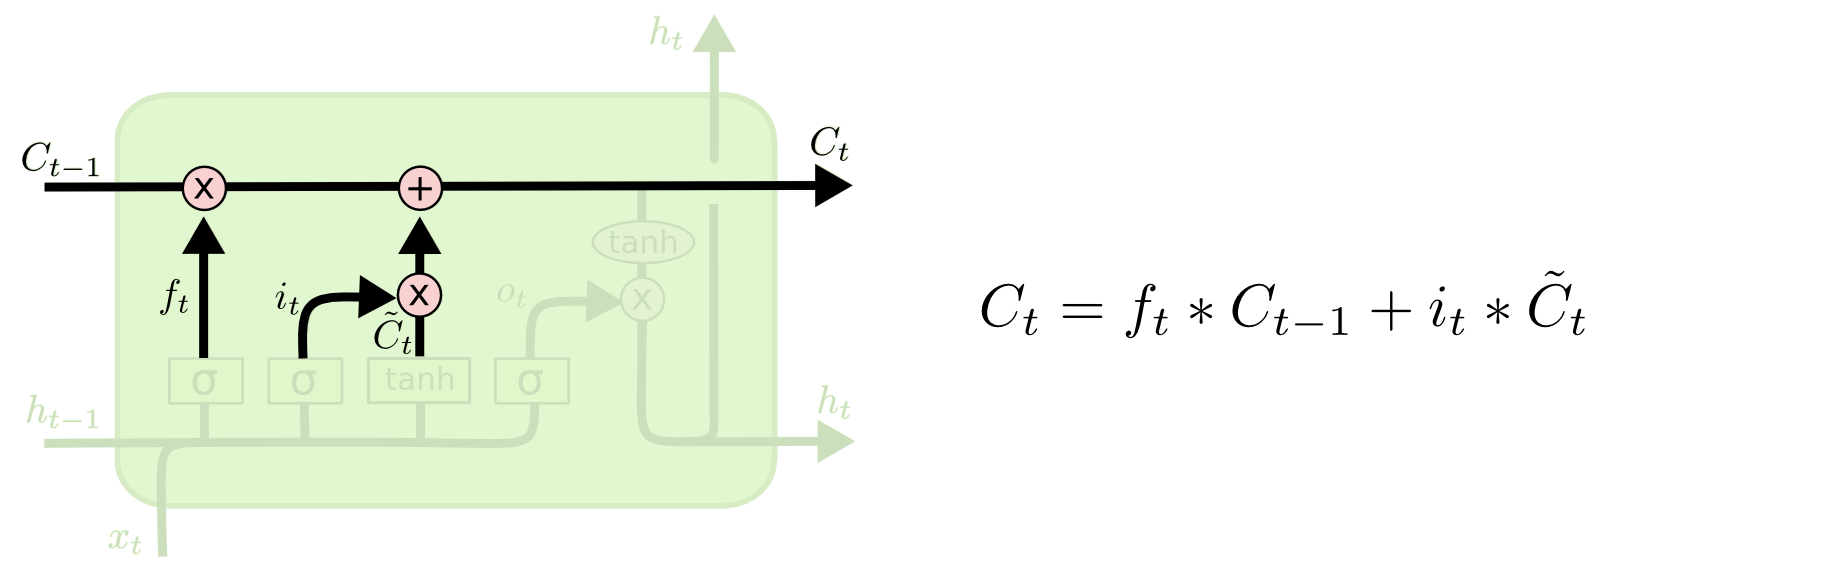

Output Gate
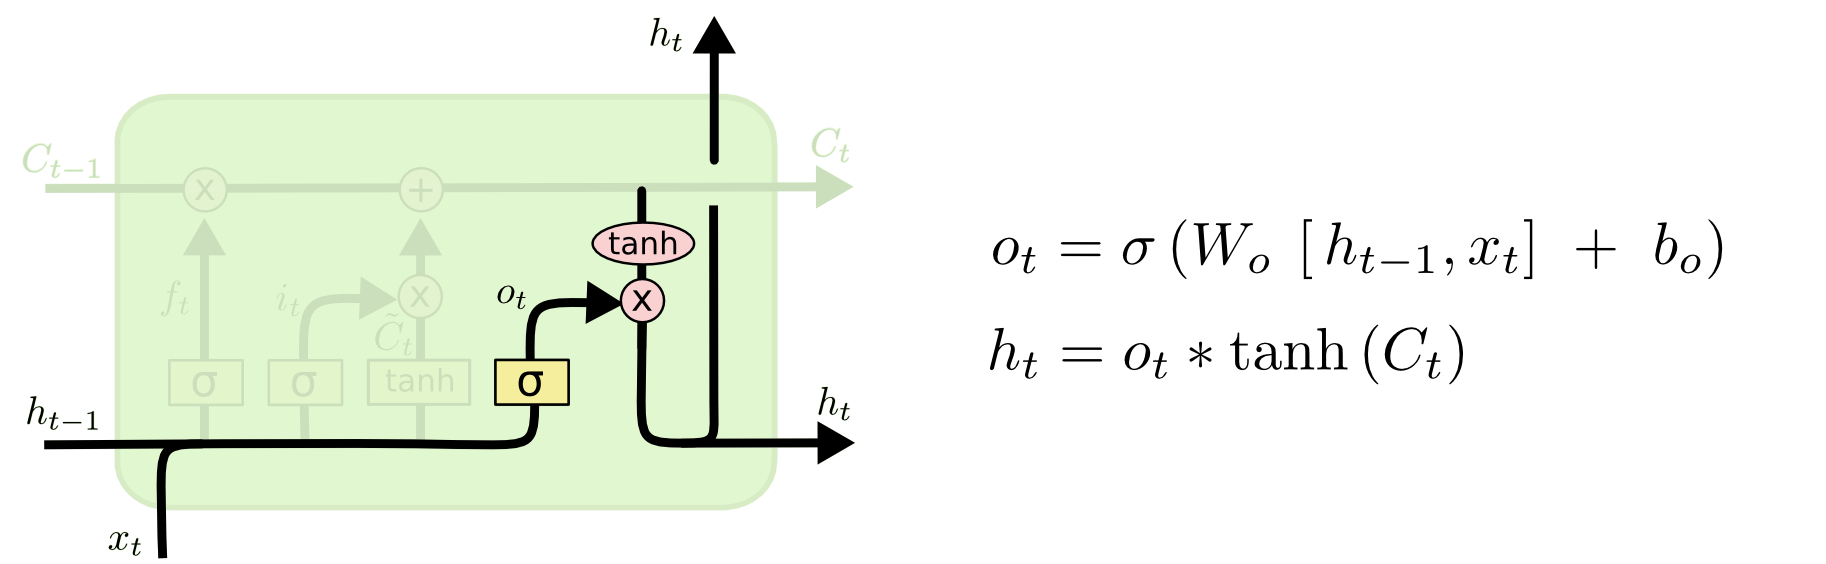

In [30]:
model4 = Sequential()
model4.add(layers.LSTM(64, activation='relu', input_shape=(n_past, n_features)))
model4.add(layers.Dense(n_features, activation='relu'))
model4.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])
model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                18432     
_________________________________________________________________
dense_10 (Dense)             (None, 7)                 455       
Total params: 18,887
Trainable params: 18,887
Non-trainable params: 0
_________________________________________________________________


In [31]:
%%time

BATCH_SIZE = 32
NUM_EPOCHS = 50

history4 = model4.fit(x=X_train_3D, y=y_train_3D, batch_size=BATCH_SIZE, validation_split = 0.2,epochs = NUM_EPOCHS, verbose=0, callbacks=[es])

Epoch 00004: early stopping
Wall time: 1.14 s


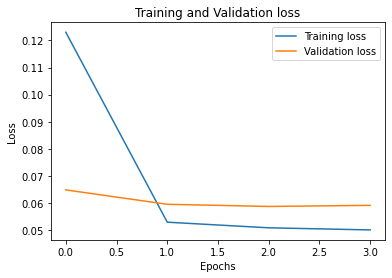

In [32]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Training and Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training loss', 'Validation loss'], loc='upper right')
plt.show()

In [33]:
model5 = Sequential()
model5.add(layers.LSTM(50, activation='relu', return_sequences=True, input_shape=(n_past, n_features)))
model5.add(layers.LSTM(50, activation='relu'))
model5.add(layers.Dense(n_features, activation='sigmoid'))
model5.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])
model5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 7, 50)             11600     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_11 (Dense)             (None, 7)                 357       
Total params: 32,157
Trainable params: 32,157
Non-trainable params: 0
_________________________________________________________________


In [34]:
%%time

BATCH_SIZE = 32
NUM_EPOCHS = 50

history5 = model5.fit(x=X_train_3D, y=y_train_3D, batch_size=BATCH_SIZE, validation_split = 0.2,epochs = NUM_EPOCHS, verbose=0, callbacks=[es])

Epoch 00007: early stopping
Wall time: 2.26 s


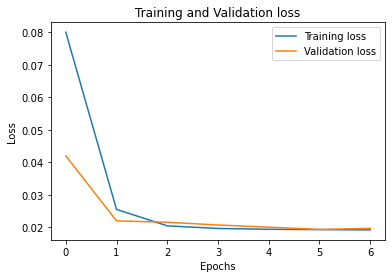

In [35]:
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Training and Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training loss', 'Validation loss'], loc='upper right')
plt.show()

In [36]:
model6 = Sequential()
model6.add(layers.Bidirectional(layers.LSTM(64, activation='relu', input_shape=(n_past, n_features))))
model6.add(layers.Dense(n_features, activation='relu'))
model6.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])
#model6.summary()

In [37]:
%%time

BATCH_SIZE = 32
NUM_EPOCHS = 50

history6 = model6.fit(x=X_train_3D, y=y_train_3D, batch_size=BATCH_SIZE, validation_split = 0.2,epochs = NUM_EPOCHS, verbose=0, callbacks=[es])

Epoch 00003: early stopping
Wall time: 1.95 s


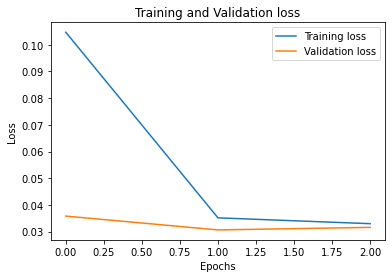

In [38]:
plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('Training and Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training loss', 'Validation loss'], loc='upper right')
plt.show()

In [39]:
# Encoder Step
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))

# create first encoder LSTM layer return 3 values:
#         1. the hidden states for each input time step,
#         2. the hidden state output for the last time step and 
#         3. the cell state for the last time step.
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]      #last hidden state

# create second encoder LSTM layer return 2 values:
#         1. the hidden state output for the last time step and 
#         2. the cell state for the last time step.
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])       #make output of layer 1 to input of layer 2
encoder_states2 = encoder_outputs2[1:]      #last cell state

# Decoder State
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = layers.TimeDistributed(layers.Dense(n_features))(decoder_l2)

#
model7 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model7.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])

model7.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 7, 7)]       0                                            
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 7, 100), (No 43200       input_4[0][0]                    
__________________________________________________________________________________________________
lstm_5 (LSTM)                   [(None, 100), (None, 80400       lstm_4[0][0]                     
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 1, 100)       0           lstm_5[0][0]                     
______________________________________________________________________________________________

In [40]:
%%time

BATCH_SIZE = 32
NUM_EPOCHS = 50

history7 = model7.fit(x=X_train_3D, y=y_train_3D, batch_size=BATCH_SIZE, validation_split = 0.2,epochs = NUM_EPOCHS, verbose=0, callbacks=[es])

Epoch 00010: early stopping
Wall time: 6.47 s


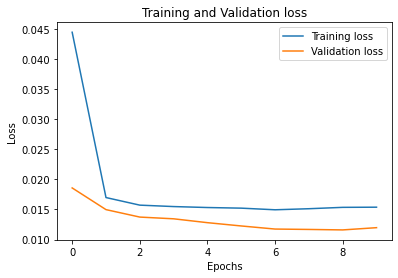

In [41]:
plt.plot(history7.history['loss'])
plt.plot(history7.history['val_loss'])
plt.title('Training and Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training loss', 'Validation loss'], loc='upper right')
plt.show()

In [42]:
tf.keras.utils.plot_model(model7, to_file='model_plot.png', show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
